# Use Sklearn models to train and predict RCC3 labels using Cross-validation

## Preamble

In [37]:
import os
import sys
import pandas as pd
import numpy as np
import json
import requests
import zipfile
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

from sklearn_models import run_train_sklearn_model
from misc import save_json, get_dropbox_dir

import matplotlib.pyplot as plt

## Load (and explain) the Data

In [11]:
# subset_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/March_8_Data'
subset_dir = '/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/March_6_Data'
# subset_dir = 'example_data'
example_data_url = 'https://www.dropbox.com/scl/fo/d1yqlmyafvu8tzujlg4nk/h?rlkey=zrxfapacmgb6yxsmonw4yt986&dl=1'
# Download the data

# download_data_dir(example_data_url, save_dir=subset_dir)

In [42]:
dropbox_dir = get_dropbox_dir()
base_dir = os.path.join(dropbox_dir, 'development_CohortCombination','alignment_RCC_2024_Feb_27')

ref_freq = 0.6
# input_freq = 0.1
grid_id = 1
matt_ft_dir = os.path.join(base_dir, 'matt_top_fts')

# %%
def get_key_ft_dct():

    matt_ft_files = os.listdir(matt_ft_dir)
    matt_ft_files = [f for f in matt_ft_files if f.endswith('.txt')]

    matt_ft_dict = {}
    for f in matt_ft_files:
        ft_name = f.split('_feats')[0]
        # with open(os.path.join(matt_ft_dir, f), 'r') as file:
        #     ft = file.read().split(', ')
        # if len(ft) == 1:
        with open(os.path.join(matt_ft_dir, f), 'r') as file:
            ft = file.read().splitlines()
            # print(file.read()
        # remove all of the ', and commas from the strings in the list
        ft = [x.strip(',').strip(' ').strip('"').strip("'").strip('\n').strip('\t') for x in ft]
        matt_ft_dict[ft_name] = ft
        # break
        print(ft_name + ': ' + str(len(ft)))

    # %% [markdown]
    # ### RCC Target Metabolites

    # %%
    # %%
    rcc_peak_info_file = os.path.join(base_dir, 'rcc_result', 'peak_info.csv')
    rcc_peak_info_df = pd.read_csv(rcc_peak_info_file, index_col=0)

    rcc_peak_info_df = rcc_peak_info_df[rcc_peak_info_df['freq'] >= ref_freq].copy()

    print(f'Number of peaks in the reference cohort after {ref_freq} filter: ', rcc_peak_info_df.shape[0])

        
    rcc_matched_targets_file = os.path.join(base_dir,'rcc_result', 'matched_targets HILIC POSITIVE ION MODE.csv')
    rcc_matched_targets_df = pd.read_csv(rcc_matched_targets_file, index_col=0)
    rcc_matched_targets_df.loc[rcc_peak_info_df.index]

    potential_feats = rcc_matched_targets_df[rcc_matched_targets_df['potential_target']].index.to_list()
    print('Number of features that potentially match to a target metabolite: ', len(potential_feats))

    double_match_ids = rcc_matched_targets_df[rcc_matched_targets_df['potential_target_count'] > 1]
    num_double_match = double_match_ids.shape[0]
    print('Number of features that potentially match to more than one target metabolite: ', double_match_ids.shape[0])
    print(rcc_matched_targets_df.loc[double_match_ids.index, 'potential_target_id'])

    # here are the double matches in RCC, two are the same metabolite (but different adducts?)
    # FT3202                           tryptophanTryptophan_μM
    # FT3237                           kynurenineKynurenine_μM
    # FT8451    C18:1 LPC plasmalogen_AC18:1 LPC plasmalogen_B


    potential_feat_names = rcc_matched_targets_df.loc[potential_feats]['potential_target_id'].unique()
    # print('Number of potential feature names: ', len(potential_feat_names))
    print(potential_feat_names)

    print('Number of target metabolite captured: ', len(potential_feat_names))

    # for now don't remove the double counts, since they are NOT actually double counts
    num_rcc_targets_found =  len(potential_feat_names)
    rcc_target_feats = potential_feats

    # add to the matt ft dictionary
    matt_ft_dict['rcc_targets'] = rcc_target_feats

    return matt_ft_dict, rcc_peak_info_df


# Helper functions to finding the number and percentage of captured features
def get_captured_fts(matt_ft_list, align_ft_list):
    captured_fts = [ft for ft in matt_ft_list if ft in align_ft_list]
    return captured_fts

def get_captured_perc(matt_ft_list, align_ft_list):
    captured_fts = get_captured_fts(matt_ft_list, align_ft_list)
    matt_capture_perc = len(captured_fts) / len(matt_ft_list)
    align_capture_perc = len(captured_fts) / len(align_ft_list)
    return matt_capture_perc, align_capture_perc


In [40]:
matt_ft_dict, rcc_peak_info_df = get_key_ft_dct()


top_10: 10
top_25: 25
168_os_pfs: 168
net_matched: 86
Number of peaks in the reference cohort after 0.6 filter:  4016
Number of features that potentially match to a target metabolite:  188
Number of features that potentially match to more than one target metabolite:  3
feats
FT3202                           tryptophanTryptophan_μM
FT3237                           kynurenineKynurenine_μM
FT8451    C18:1 LPC plasmalogen_AC18:1 LPC plasmalogen_B
Name: potential_target_id, dtype: object
['trimethylamine-N-oxide' 'alanine' 'GABA' 'serine' 'hypotaurine'
 'cytosine' 'creatinine' 'betaine' 'threonine' 'niacinamide' 'taurine'
 'ornithine' 'N-acetylalanine' 'N-carbamoyl-beta-alanine'
 'N-methylproline' 'leucine' 'hydroxyproline' 'N-acetylputrescine'
 '1-methylnicotinamide' 'trigonelline' 'anthranilic acid' 'urocanic acid'
 'imidazole propionate' 'ectoine' 'proline-betaine' 'glutamate'
 '4-acetamidobutanoate' 'butyrobetaine' 'glutamine' 'lysine' 'methionine'
 'N1-methyl-2-pyridone-5-carboxamide' 

In [12]:
#what is inside the example directory?
print(os.listdir(subset_dir))

['Nivo Benefit BINARY finetune_folds', '.DS_Store', 'MSKCC BINARY finetune_folds', 'Cohort ID Expanded pretrain_folds', 'readme.txt', 'X.csv', 'y.csv', 'nans.csv']


#### X data
- the input peak matrix, columns are peaks, rows are samples
- nans are already imputed using the mean of the peak within its corresponding study
- in this example, the peaks are those determined by alignment
- also in this example, we are including a lot of pretraining data

In [13]:
X_data = pd.read_csv(os.path.join(subset_dir, 'X.csv'), index_col=0)

#### Nan mask
- nans is a binary matrix indicating which peaks were originally missing in which samples
- columns are the peaks, rows are the samples
- should have the exact same size and organization as X data
- Since nans were already imputed, this is not used in this example
- is useful if you want to change the imputation method, or calculate peak frequency

In [14]:
nan_mask = pd.read_csv(os.path.join(subset_dir, 'nans.csv'), index_col=0)



#### Y data
- the metadata associated with the samples
- includes metadata from alignment with pre-training data AND metadata associated with the RCC studies
- RCC related metadata has been cleaned and simplified. combines the information between genomics dataset, the the Nature communication dataset. A lot of superfolous information has been removed
- the "Matt Set" column indicates whether a sample belongs in Matt's Train/Val/Split
- the "Set" column corresponds to the "Matt Set" for the RCC3 *baseline* samples, all other samples are labeled as pretrai
- columns have been created specifically for the Binary classification task "Nivo Benefit BINARY" and "MSKCC BINARY". 

In [ ]:
rcc_metadata_file = os.path.join(dropbox_dir, 'development_CohortCombination','clean_rcc_metadata_encoded.csv')
rcc_metadata = pd.read_csv(rcc_metadata_file, index_col=0)

In [15]:
y_data = pd.read_csv(os.path.join(subset_dir, 'y.csv'), index_col=0)

In [16]:
y_data.columns

Index(['cohort_id', 'Study ID', 'Cohort Label', 'Cohort ID Expanded',
       'Study ID Expanded', 'Cohort ID', 'OS', 'OS_Event', 'Age', 'subject ID',
       'study_week', 'Region', 'Sex', 'Race', 'Dose (mg/kg)', 'phase',
       'Treatment', 'Prior_2', 'batch_id', 'runtime_hour', 'run_order',
       'MSKCC', 'ORR', 'Benefit', 'ExtremeResponder', 'PFS', 'PFS_Event', 'MV',
       'Age_Group', 'Benefit BINARY', 'Benefit ORDINAL', 'Nivo Benefit BINARY',
       'MSKCC BINARY', 'MSKCC ORDINAL', 'Matt Set', 'Set'],
      dtype='object')

In [17]:
y_data['Study ID'].value_counts().nunique()

18

In [9]:
y_data['Set'].value_counts()

Set
Pretrain      16944
Finetune        449
Test            149
Validation      143
Name: count, dtype: int64

In [10]:
print('number of samples: ', X_data.shape[0])
print('number of features: ', X_data.shape[1])

number of samples:  17685
number of features:  2736


In [18]:
pretrain_files = y_data[y_data['Set']=='Pretrain'].index.to_list()
finetune_files = y_data[y_data['Set']=='Finetune'].index.to_list()
holdout_test_files = y_data[y_data['Set']=='Test'].index.to_list()
holdout_val_files = y_data[y_data['Set']=='Validation'].index.to_list()

## Run Classical Models on the desired tasks

### Create the task directory and properly format the X and y for the task

In [19]:
yes_dropna = True

finetune_label_col = 'MSKCC BINARY'
finetune_label_mapper = {}
finetune_filter = []

desc_str = 'MSKCC BINARY'
desc_str = finetune_label_col

splits_dir = os.path.join(subset_dir, f'{desc_str} finetune_folds')


print(finetune_label_col)
print(finetune_label_mapper)


task_dir = os.path.join(splits_dir, finetune_label_col)

MSKCC BINARY
{}


In [20]:
finetune_freq = 1 - nan_mask.loc[finetune_files].sum(axis=0)/ len(finetune_files)
pretrain_freq = 1- nan_mask.loc[pretrain_files].sum(axis=0)/ len(pretrain_files)
finetune_var = X_data.loc[finetune_files].var(axis=0)

Text(0.5, 0, 'Fraction of non-NaN values in Training Data')

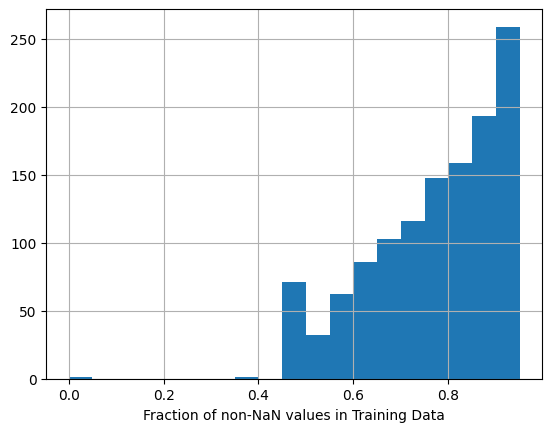

In [21]:
finetune_freq.hist(bins=np.arange(0,1,0.05))
plt.xlabel('Fraction of non-NaN values in Training Data')

Text(0.5, 0, 'Fraction of non-NaN values in Pretraining Data')

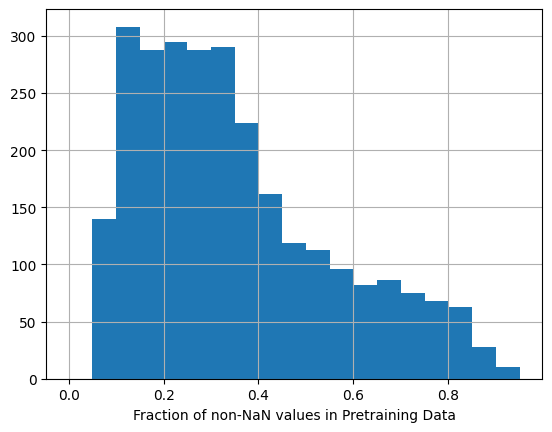

In [22]:
pretrain_freq.hist(bins=np.arange(0,1,0.05))
plt.xlabel('Fraction of non-NaN values in Pretraining Data')

Text(0.5, 0, 'Peak Variance in Finetune Data')

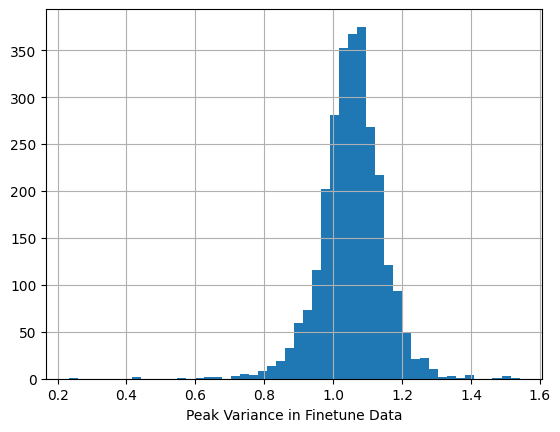

In [23]:
finetune_var.hist(bins=50)
plt.xlabel('Peak Variance in Finetune Data')

## Chose a fraction of the peaks 

In [30]:
temp = pd.concat([finetune_freq, pretrain_freq, finetune_var], axis=1)
temp.columns = ['finetune_freq', 'pretrain_freq', 'finetune_var']
print(temp.shape)

(2736, 3)


In [45]:
# check that the Matt feats are found in the RCC peaks
print('In the peaks of size ', temp.shape[0])
for matt_ft_name, matt_ft_list in matt_ft_dict.items():
    captured_peaks = get_captured_fts(matt_ft_list, temp.index)
    print(f'Number of {matt_ft_name} captured: {len(captured_peaks)} out of {len(matt_ft_list)}: {len(captured_peaks)/len(matt_ft_list):.2f}')

In the peaks of size  2736
Number of top_10 captured: 10 out of 10: 1.00
Number of top_25 captured: 23 out of 25: 0.92
Number of 168_os_pfs captured: 134 out of 168: 0.80
Number of net_matched captured: 73 out of 86: 0.85
Number of rcc_targets captured: 159 out of 188: 0.85


In [78]:
finetune_var_q = 0.05
finetune_var_th = temp['finetune_var'].quantile(finetune_var_q)
print(finetune_var_th)
# finetune_var_th = 0.5#0.75
finetune_freq_th = 0.9
pretrain_freq_th = 0.3 #0.35

finetune_filter = (finetune_var >= finetune_var_th) & (finetune_freq >= finetune_freq_th) & (pretrain_freq >= pretrain_freq_th)

temp_filter = temp[finetune_filter]
print(temp_filter.shape)


print('In the peaks of size ', temp_filter.shape[0])
for matt_ft_name, matt_ft_list in matt_ft_dict.items():
    captured_peaks = get_captured_fts(matt_ft_list, temp_filter.index)
    print(f'Number of {matt_ft_name} captured: {len(captured_peaks)} out of {len(matt_ft_list)}: {len(captured_peaks)/len(matt_ft_list):.2f}')

0.9068523076506994
(941, 3)
In the peaks of size  941
Number of top_10 captured: 2 out of 10: 0.20
Number of top_25 captured: 9 out of 25: 0.36
Number of 168_os_pfs captured: 52 out of 168: 0.31
Number of net_matched captured: 26 out of 86: 0.30
Number of rcc_targets captured: 84 out of 188: 0.45


In [29]:
temp

,finetune_freq,pretrain_freq,finetune_var
FT10031,0.463252,0.272486,1.035956
FT10035,0.982183,0.227632,1.027943
FT10037,0.467706,0.396542,1.079680
FT10039,0.982183,0.296978,0.976793
FT10041,1.000000,0.267764,1.045069
...,...,...,...
FT9985,0.759465,0.147014,0.968094
FT9988,0.859688,0.196471,1.147949
FT9989,0.979955,0.348737,1.038769
FT9997,0.953229,0.260033,1.082380


In [13]:
# Create the Train, Val, and Test data sets

X_train = X_data.loc[finetune_files]
y_train = y_data.loc[finetune_files, finetune_label_col]
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]


X_val = X_data.loc[holdout_val_files]
y_val = y_data.loc[holdout_val_files, finetune_label_col]
y_val = y_val.dropna()
X_val = X_val.loc[y_val.index]


X_test = X_data.loc[holdout_test_files]
y_test = y_data.loc[holdout_test_files, finetune_label_col]
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]


In [64]:
import sklearn
print('sklearn version: ', sklearn.__version__)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

In [22]:
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)
# n_iter = 10
# verbose = 0

# def scoring_func(estimator, X, y):
#     y_prob = estimator.predict_proba(X)[:,1]
#     return roc_auc_score(y, y_prob, average='weighted')

In [76]:
def my_sklearn_fitter(data_dict, param_grid, 
                      output_dir, model_kind, model_name,
                      cv=None, n_iter=10, scoring_func=None, verbose=0):
    if cv is None:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)
    
    if scoring_func is None:
        # depends on which sklearn version we are using
        # scoring_func = make_scorer(roc_auc_score, average='weighted', response_method='predict_proba')
        scoring_func = make_scorer(roc_auc_score, average='weighted', needs_proba=True)

    if model_kind == 'logistic_regression':
        base_model = LogisticRegression(max_iter=1000)
    elif model_kind == 'random_forest':
        base_model = RandomForestClassifier()
    elif model_kind == 'decision_tree':
        base_model = DecisionTreeClassifier()
    elif model_kind == 'svc':
        base_model = SVC(probability=True)

    model = RandomizedSearchCV(base_model, 
                               param_distributions=param_grid, 
                               n_iter=n_iter, 
                               cv=cv, 
                               scoring=scoring_func, 
                               verbose=verbose, 
                               random_state=1010,
                               n_jobs=1)
    X_train, y_train = data_dict['X_train'], data_dict['y_train']
    X_val, y_val = data_dict['X_val'], data_dict['y_val']
    X_test, y_test = data_dict['X_test'], data_dict['y_test']

    model.fit(X_train, y_train)

    model_results = pd.DataFrame(model.cv_results_)

    model_results.sort_values('rank_test_score', inplace=True)
    model_results.iloc[0]['mean_test_score']
    cv_score = model_results.iloc[0]['mean_test_score']
    cv_score_std = model_results.iloc[0]['std_test_score']
    print(f'Train CV score: {cv_score} +/- {cv_score_std}')


    y_train_proba = model.predict_proba(X_train)[:,1]
    train_score = roc_auc_score(y_train, y_train_proba, average='weighted')
    print(f'Training score: {train_score}')


    y_val_proba = model.predict_proba(X_val)[:,1]
    val_score = roc_auc_score(y_val, y_val_proba, average='weighted')
    print(f'Validation score: {val_score}')


    y_test_proba = model.predict_proba(X_test)[:,1]
    test_score = roc_auc_score(y_test, y_test_proba, average='weighted')
    print(f'Test score: {test_score}')


    model_summary = {
        'model_kind': model_kind,
        'model_name': model_name,
        'n_input ft': X_train.shape[1],
        'param_grid' : param_grid,
        'best_params': model.best_params_,
        'score name': 'roc_auc (weighted)',
        'cv_score': cv_score,
        'cv_score_std': cv_score_std,
        'train_score': train_score,
        'val_score': val_score,
        'test_score': test_score,
        'train sz': X_train.shape[0],
        'val sz': X_val.shape[0],
        'test sz': X_test.shape[0],
    }

    save_json(model_summary, os.path.join(output_dir, f'{model_name}_summary.json'))

    return model_summary

In [79]:
var_quantile = 0.
for var_quantile in [0,0.05,0.1,0.2,0.25,0.33,0.5]:

    chosen_fts = finetune_var[finetune_var>finetune_var.quantile(var_quantile)].index.to_list()
    feat_filt_name = 'var q{}'.format(var_quantile)


    param_grid = {
                'penalty': ['l1', 'l2'],
                'C': [0.005, 0.1, 0.5, 1, 2, 5, 10],
                'solver' : ['liblinear'],
                'class_weight': ['balanced']
                }

    model_kind = 'logistic_regression' 
    model_name = f'{model_kind} optimal'  + f'_{feat_filt_name}'
    output_dir = os.path.join(task_dir, 'classical_models_alt')

    data_dict = {'X_train': X_train[chosen_fts], 
                'y_train': y_train, 
                'X_val': X_val[chosen_fts], 
                'y_val': y_val, 
                'X_test': X_test[chosen_fts], 
                'y_test': y_test}


    out = my_sklearn_fitter(data_dict, param_grid, 
                        output_dir, model_kind, model_name)

Train CV score: 0.9002987502964895 +/- 0.03896609936556677
Training score: 1.0
Validation score: 0.8724489795918368
Test score: 0.9145299145299145
Train CV score: 0.8972884176351993 +/- 0.039409576371011154
Training score: 1.0
Validation score: 0.8731778425655978
Test score: 0.9138176638176638
Train CV score: 0.899369514943074 +/- 0.03948372857823047
Training score: 1.0
Validation score: 0.8709912536443148
Test score: 0.9116809116809117
Train CV score: 0.8964920096062617 +/- 0.040219899490247964
Training score: 1.0
Validation score: 0.8644314868804666
Test score: 0.9081196581196581
Train CV score: 0.8961666493714421 +/- 0.04129368129163213
Training score: 0.9999236874236874
Validation score: 0.8651603498542275
Test score: 0.9045584045584044
Train CV score: 0.8982221003320684 +/- 0.04055922191551272
Training score: 0.9999236874236874
Validation score: 0.8709912536443147
Test score: 0.8981481481481481
Train CV score: 0.8930581045422202 +/- 0.041262554436873766
Training score: 0.998778998

In [82]:
output_files = os.listdir(output_dir)
output_summary_files = [f for f in output_files if f.endswith('summary.json')]
other_files = [f for f in output_files if f not in output_summary_files]

all_res = []
df_cols = ['model_kind','model_name','n_input ft','cv_score','train_score','val_score', 'test_score']
for f in output_summary_files:
    print(f)
    model_name = f.split('_summary.json')[0]
    res = json.load(open(os.path.join(output_dir, f)))
    res_df = pd.DataFrame({k: res[k] for k in df_cols}, index=[model_name])
    all_res.append(res_df)


res_summary = pd.concat(all_res, axis=0)    
res_summary = res_summary.round(4)
res_summary.to_csv(os.path.join(task_dir, 'classical_alt_summary.csv'))

logistic_regression optimal_var q0.1_summary.json
logistic_regression optimal_var q0_summary.json
logistic_regression optimal_var q0.33_summary.json
logistic_regression optimal_var q0.05_summary.json
logistic_regression optimal_var q0.25_summary.json
logistic_regression optimal_var q0.5_summary.json
logistic_regression optimal_var q0.2_summary.json


## Notepad

In [75]:
param_grid = {
            'penalty': ['l1', 'l2'],
            'C': [0.005, 0.1, 0.5, 1, 2, 5, 10],
            'solver' : ['liblinear'],
            'class_weight': ['balanced']
            }
model_kind = 'logistic_regression' 
model_name = f'{model_kind} optimal1'   
output_dir = os.path.join(task_dir, 'classical_models_alt')


out2 = my_sklearn_fitter(data_dict, param_grid, 
                      output_dir, model_kind, model_name)

Train CV score: 0.9003188374644213 +/- 0.03904511044706044
Training score: 1.0
Validation score: 0.8731778425655976
Test score: 0.9145299145299145


In [72]:
param_grid = {
            'penalty': ['l1', 'l2'],
            'C': [0.005, 0.1, 0.5, 1, 2, 5, 10],
            'solver' : ['liblinear'],
            'class_weight': ['balanced']
            }
model_kind = 'logistic_regression' 
model_name = f'{model_kind} optimal1'   
output_dir = os.path.join(task_dir, 'classical_models_alt')


out1 = my_sklearn_fitter(data_dict, param_grid, 
                      output_dir, model_kind, model_name)

/Users/jonaheaton/opt/miniconda3/envs/mzlearn_3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 14 is smaller than n_iter=50. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Train CV score: 0.9003188374644213 +/- 0.03904511044706044
Training score: 1.0
Validation score: 0.8731778425655976
Test score: 0.9145299145299145


In [23]:
base_model = LogisticRegression(max_iter=1000)
param_grid = {
            'penalty': ['l1', 'l2'],
            'C': [0.005, 0.1, 0.5, 1, 2, 5, 10],
            'solver' : ['liblinear'],
            'class_weight': ['balanced']
            }
model = RandomizedSearchCV(base_model, param_distributions=param_grid, 
                        n_iter=n_iter, cv=cv, verbose=verbose, 
                        random_state=1010, n_jobs=-1, scoring=scoring_func)


model.fit(X_train, y_train)
# save the model results
model_results = pd.DataFrame(model.cv_results_)
best_model = model.best_estimator_

In [30]:
model_results.sort_values('rank_test_score', inplace=True)
model_results.iloc[0]['mean_test_score']
cv_score = model_results.iloc[0]['mean_test_score']
cv_score_std = model_results.iloc[0]['std_test_score']
print(f'Train CV score: {cv_score} +/- {cv_score_std}')

Train CV score: 0.9003188374644213 +/- 0.03904511044706044


In [29]:
y_train_proba = best_model.predict_proba(X_train)[:,1]
train_score = roc_auc_score(y_train, y_train_proba, average='weighted')
print(f'Training score: {train_score}')

Training score: 1.0


In [32]:
y_val_proba = best_model.predict_proba(X_val)[:,1]
val_score = roc_auc_score(y_val, y_val_proba, average='weighted')
print(f'Validation score: {val_score}')

Validation score: 0.8731778425655976


In [33]:
y_test_proba = best_model.predict_proba(X_test)[:,1]
test_score = roc_auc_score(y_test, y_test_proba, average='weighted')
print(f'Test score: {test_score}')

Test score: 0.9145299145299145


In [39]:
model_summary = {
    'model_kind': model_kind,
    'model_name': model_name,
    'param_grid' : param_grid,
    'best_params': model.best_params_,
    'cv_score': cv_score,
    'cv_score_std': cv_score_std,
    'train_score': train_score,
    'val_score': val_score,
    'test_score': test_score
}

save_json(model_summary, os.path.join(output_dir, f'{model_name}_summary.json'))

In [36]:
model_summary

{'model_kind': 'logistic_regression',
 'model_name': 'logistic_regression optimal',
 'param_grid': {'penalty': ['l1', 'l2'],
  'C': [0.005, 0.1, 0.5, 1, 2, 5, 10],
  'solver': ['liblinear'],
  'class_weight': ['balanced']},
 'best_params': {'solver': 'liblinear',
  'penalty': 'l2',
  'class_weight': 'balanced',
  'C': 0.005},
 'cv_score': 0.9003188374644213,
 'cv_score_std': 0.03904511044706044,
 'train_score': 1.0,
 'val_score': 0.8731778425655976,
 'test_score': 0.9145299145299145}

### cycle over the different models and run repeated cross-validation


In [43]:
output_files = os.listdir(output_dir)
output_summary_files = [f for f in output_files if f.endswith('summary.json')]
other_files = [f for f in output_files if f not in output_summary_files]

all_res = []
df_cols = ['model_kind','model_name','n_input ft','cv_score','train_score','val_score', 'test_score']
for f in output_summary_files:
    print(f)
    model_name = f.split('_summary.json')[0]
    res = json.load(open(os.path.join(output_dir, f)))
    res_df = pd.DataFrame({k: res[k] for k in df_cols}, index=[model_name])


res_summary = pd.concat(all_res, axis=1)    
res_summary = res_summary.round(4)
# res_summary.to_csv(os.path.join(task_dir, 'classical_summary.csv'))

logistic_regression optimal_summary.json


ValueError: No objects to concatenate

In [45]:
res_df 


,model_kind,model_name,cv_score,cv_score_std,train_score,val_score,test_score
logistic_regression optimal,logistic_regression,logistic_regression optimal,0.900319,0.039045,1.0,0.873178,0.91453


In [41]:
res

{'model_kind': 'logistic_regression',
 'model_name': 'logistic_regression optimal',
 'param_grid': {'penalty': ['l1', 'l2'],
  'C': [0.005, 0.1, 0.5, 1, 2, 5, 10],
  'solver': ['liblinear'],
  'class_weight': ['balanced']},
 'best_params': {'solver': 'liblinear',
  'penalty': 'l2',
  'class_weight': 'balanced',
  'C': 0.005},
 'cv_score': 0.9003188374644213,
 'cv_score_std': 0.03904511044706044,
 'train_score': 1.0,
 'val_score': 0.8731778425655976,
 'test_score': 0.9145299145299145}

In [30]:
val_hold_idx = holdout_val_files
Xval = X_data.loc[val_hold_idx]
yval = y_data.loc[val_hold_idx, finetune_label_col]
if yes_dropna:
    yval = yval.dropna()
    Xval = Xval.loc[yval.index]

In [31]:
output_dir = os.path.join(task_dir, 'classical_models')
if finetune_label_mapper:
    y_values = y[finetune_label_col].map(finetune_label_mapper)
else:
    y_values = y[finetune_label_col]
    
if yes_dropna:
    print('dropping nan values in the y column')
    y_values = y_values.dropna()
    X = X.loc[y_values.index]
    splits_df = splits_df.loc[y_values.index]

    print('number of samples after dropping nan values in the y column: ', y_values.shape[0])    


dropping nan values in the y column
number of samples after dropping nan values in the y column:  240


In [25]:
delete_other_files = False #delete the files generated from each fitting in the repeated Cross-validation
optimization_desc = 'default' #use sklearn's default hyperparameters
# optimization_desc = 'optimal' # use the default hyperparameter gridsearch specified in run_train_sklearn_model

which_models = ['logistic_regression', 'random_forest', 'svc']
# which_models = ['logistic_regression']


for model_kind in which_models:
    gather_output = []
    model_name = model_kind + '_' + optimization_desc
    output_summary_file = os.path.join(output_dir, f'{model_name}_summary.csv')
    
    if optimization_desc == 'default':
        param_grid = {}
    elif optimization_desc == 'optimal':
        param_grid = None # use the default hyperparameter gridsearch specified in run_train_sklearn_model

    for subset_id in range(n_folds):



        train_idx = splits_df.index[splits_df[f'fold_{subset_id}'] == False]
        test_idx = splits_df.index[splits_df[f'fold_{subset_id}'] == True]
        finetune_dataset = SimpleDataset(X.loc[train_idx], y_values.loc[train_idx])
        
        class_weights = 1 / torch.bincount(finetune_dataset.y.long())

        test_dataset = SimpleDataset(X.loc[test_idx], y_values.loc[test_idx])

        data_dict = {'train': finetune_dataset, 'CV': test_dataset}

        #if you want to add the validation set to the final evaluation
        data_dict['val'] = SimpleDataset(Xval, yval)

        ##### ##### ##### ##### ##### ##### ##### ##### ##### #####
        ##### Here is the code that actually runs the model optimization #####
        output_data = run_train_sklearn_model(data_dict,output_dir,
                                model_kind = model_kind,
                                model_name=f'{model_name}_{subset_id}',
                                param_grid=param_grid
                                )
        ##### ##### ##### ##### ##### ##### ##### ##### ##### #####
        

        gather_output.append(output_data)

    ## Summarize the important results
    # best_epoch_list = [output['best_epoch'] for output in gather_output]
        
    auc_summary_dct = {}
    for phase in data_dict.keys():
        auc_summary_dct[phase + ' AUROC'] = [output['end_state_auroc'][phase] for output in gather_output]

    # cv_auroc_list = [output['end_state_auroc']['CV'] for output in gather_output]
    # train_auroc_list = [output['end_state_auroc']['train'] for output in gather_output]
    # model_name = gather_output[0]['model_name']
    auc_summary = pd.DataFrame(auc_summary_dct)


    result_summary_avg = auc_summary.mean()
    result_summary_std = auc_summary.std()
    result_summary_avg.index = [f'AVG {col}' for col in result_summary_avg.index]
    result_summary_std.index = [f'STD {col}' for col in result_summary_std.index]
    result_summary = pd.concat([result_summary_avg, result_summary_std])
    result_summary.to_csv(output_summary_file)





output_files = os.listdir(output_dir)
output_summary_files = [f for f in output_files if f.endswith('summary.csv')]
other_files = [f for f in output_files if f not in output_summary_files]

all_res = []

for f in output_summary_files:
    print(f)
    model_name = f.split('_summary.csv')[0]
    res = pd.read_csv(os.path.join(output_dir, f), index_col=0)
    res.columns = [model_name]
    all_res.append(res)
    
# delete the other files to save room
if delete_other_files:
    for f in other_files:
        os.remove(os.path.join(output_dir, f))    

res_summary = pd.concat(all_res, axis=1)    
res_summary = res_summary.round(4)
res_summary.to_csv(os.path.join(task_dir, 'classical_summary.csv'))


dropping nan values in the y column
number of samples after dropping nan values in the y column:  156
svc_default_summary.csv
logistic_regression_default_summary.csv
random_forest_default_summary.csv


In [32]:
data_dict = {}
data_dict['train'] = SimpleDataset(X, y_values)
data_dict['test'] = SimpleDataset(Xval, yval)

for model_kind in which_models:

        model_name = model_kind + '_' + optimization_desc +' val'

        output_data = run_train_sklearn_model(data_dict,output_dir,
                                model_kind = model_kind,
                                model_name=f'{model_name}',
                                param_grid=param_grid
                                )
        
        valauc = output_data['end_state_auroc']['test']
        print(f'{model_name} val auc: {valauc}')
        

logistic_regression_default val val auc: 0.8607871532440186
random_forest_default val val auc: 0.931851327419281
svc_default val val auc: 0.9256560802459717


In [26]:
test_dataset

In [11]:
res_summary.round(3)

,svc_default,logistic_regression_default,logistic_regression_optimal,random_forest_default
AVG train AUROC,0.980,1.000,0.998,1.000
AVG CV AUROC,0.646,0.655,0.634,0.629
STD train AUROC,0.141,0.000,0.008,0.000
STD CV AUROC,0.090,0.074,0.080,0.074


In [21]:
auc_summary

,train AUROC,CV AUROC,val AUROC
0,0.999881,0.891841,0.908163
1,1.000000,0.857685,0.919096
2,1.000000,0.973435,0.924198
3,0.999761,0.884250,0.934402
4,0.999881,0.882812,0.930029
5,1.000000,0.941176,0.927114
6,1.000000,0.920304,0.910350
7,0.999761,0.861480,0.931487
8,1.000000,0.872865,0.917638
9,1.000000,0.845703,0.928572


In [14]:
# how to check if a variable is a function
callable(run_train_sklearn_model)

True

In [16]:
callable(subset_dir)

False

In [17]:
X_data.shape

(17685, 2736)

In [19]:
X_data.sum(axis=0)/X_data.shape[0]

FT10031   -0.002666
FT10035   -0.005164
FT10037   -0.003603
FT10039   -0.004585
FT10041   -0.007062
             ...   
FT9985    -0.007561
FT9988    -0.006673
FT9989    -0.004516
FT9997    -0.006612
FT9999    -0.008210
Length: 2736, dtype: float64